In [1]:
import os
import random

import pickle
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

custom_seed = 42
np.random.seed(custom_seed)
tf.random.set_seed(custom_seed)

In [2]:
def load_data_and_results(model_name):
    data_folder = r' HERE GOES DATA FOLDER '
    name_data_archive = f'{model_name}_data.pkl'
    pickle_archive = os.path.join(data_folder, name_data_archive)

    with open(pickle_archive, 'rb') as f:
        data = pickle.load(f)

    # Load first training
    results_folder = r' HERE GOES RESULTS FOLDER'
    archive_name_first_train = f'{model_name}_results\{model_name}_first_train.pkl'
    pickle_archive = os.path.join(results_folder, archive_name_first_train)

    with open(pickle_archive, 'rb') as f:
        results_first_train_pkl = pickle.load(f)

    results_first_train = results_first_train_pkl['training']
    predictions_predictive_first_train = results_first_train_pkl['predictions_pred']
    predictions_explanatory_first_train = results_first_train_pkl['predictions_exp']

    # Load new training
    archive_name_new_train = f'{model_name}_results\{model_name}_new_train.pkl'
    pickle_archive = os.path.join(results_folder, archive_name_new_train)

    with open(pickle_archive, 'rb') as f:
        results_new_train_pkl = pickle.load(f)

    results_new_train = results_new_train_pkl['training']
    predictions_predictive_new_train = results_new_train_pkl['predictions_pred']
    predictions_explanatory_new_train = results_new_train_pkl['predictions_exp']

    return data, results_first_train, predictions_predictive_first_train, predictions_explanatory_first_train, results_new_train, predictions_predictive_new_train, predictions_explanatory_new_train

In [3]:
# Model "heterogeneous_problem"
data_heterogeneous_problem, results_first_train_heterogeneous_problem, predictions_predictive_first_train_heterogeneous_problem, predictions_explanatory_first_train_heterogeneous_problem, results_new_train_heterogeneous_problem, predictions_predictive_new_train_heterogeneous_problem, predictions_explanatory_new_train_heterogeneous_problem = load_data_and_results("heterogeneous_problem")

# Model "tensorial_problem"
data_tensorial_problem, results_first_train_tensorial_problem, predictions_predictive_first_train_tensorial_problem, predictions_explanatory_first_train_tensorial_problem, results_new_train_tensorial_problem, predictions_predictive_new_train_tensorial_problem, predictions_explanatory_new_train_tensorial_problem = load_data_and_results("tensorial_problem")

# Model "nonlinear_problem_P3"
data_nonlinear_problem_P3, results_first_train_nonlinear_problem_P3, predictions_predictive_first_train_nonlinear_problem_P3, predictions_explanatory_first_train_nonlinear_problem_P3, results_new_train_nonlinear_problem_P3, predictions_predictive_new_train_nonlinear_problem_P3, predictions_explanatory_new_train_nonlinear_problem_P3 = load_data_and_results("nonlinear_problem_P3")

# Model "nonlinear_problem_P4"
data_nonlinear_problem_P4, results_first_train_nonlinear_problem_P4, predictions_predictive_first_train_nonlinear_problem_P4, predictions_explanatory_first_train_nonlinear_problem_P4, results_new_train_nonlinear_problem_P4, predictions_predictive_new_train_nonlinear_problem_P4, predictions_explanatory_new_train_nonlinear_problem_P4 = load_data_and_results("nonlinear_problem_P4")

In [4]:
n_data = data_nonlinear_problem_P4['n_data']
n_discretization = data_nonlinear_problem_P4['n_discretization']
x_step_size = data_nonlinear_problem_P4['x_step_size']
y_step_size = data_nonlinear_problem_P4['y_step_size']

In [5]:
# Finite difference convolutional operator to derivate in x axis
def Dx(f, x_step_size=x_step_size):
    Dx = tf.constant([[-1, +1], 
                      [-1, +1]], 
                     dtype=tf.float32)/(2*x_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dx = tf.expand_dims(tf.expand_dims(Dx, axis=-1), axis=-1)
    dfdx = tf.nn.conv2d(f_reshaped, Dx, strides=[1, 1, 1, 1], padding='VALID', name='dfdx')
    return tf.squeeze(dfdx, axis=-1)

# Finite difference convolutional operator to derivate in y axis
def Dy(f, y_step_size=y_step_size):
    Dy = tf.constant([[+1, +1], 
                      [-1, -1]],  
                     dtype=tf.float32)/(-2*y_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dy = tf.expand_dims(tf.expand_dims(Dy, axis=-1), axis=-1)
    dfdy = tf.nn.conv2d(f_reshaped, Dy, strides=[1, 1, 1, 1], padding='VALID', name='dfdy')
    return tf.squeeze(dfdy, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in x axis
def Mx(f):
    Mx = tf.constant([[+1, +1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Mx = tf.expand_dims(tf.expand_dims(Mx, axis=-1), axis=-1)
    x_avg = tf.nn.conv2d(f_reshaped, Mx, strides=[1, 1, 1, 1], padding='VALID', name='Mx')
    return tf.squeeze(x_avg, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in y axis
def My(f):
    My = tf.constant([[+1], 
                      [+1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    My = tf.expand_dims(tf.expand_dims(My, axis=-1), axis=-1)
    y_avg = tf.nn.conv2d(f_reshaped, My, strides=[1, 1, 1, 1], padding='VALID', name='My')
    return tf.squeeze(y_avg, axis=-1)

In [6]:
def smooth_curve(data, window_size=100):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = max(lst)
    return [x / max_value for x in lst]

Graphics parameters

In [7]:
linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [8]:
# Training curves of heterogeneous problem
train_total_loss_list_heterogeneous_problem = results_first_train_heterogeneous_problem['train_total_loss_list'] + results_new_train_heterogeneous_problem['train_total_loss_list']
test_total_loss_list_heterogeneous_problem = results_first_train_heterogeneous_problem['test_total_loss_list'] + results_new_train_heterogeneous_problem['test_total_loss_list']
train_total_MSE_list_heterogeneous_problem = results_first_train_heterogeneous_problem['train_total_MSE_list'] + results_new_train_heterogeneous_problem['train_total_MSE_list']
test_total_MSE_list_heterogeneous_problem = results_first_train_heterogeneous_problem['test_total_MSE_list'] + results_new_train_heterogeneous_problem['test_total_MSE_list']

# Training curves of tensorial problem
data_tensorial_problem, results_first_train_tensorial_problem, predictions_predictive_first_train_tensorial_problem, predictions_explanatory_first_train_tensorial_problem, results_new_train_tensorial_problem, predictions_predictive_new_train_tensorial_problem, predictions_explanatory_new_train_tensorial_problem = load_data_and_results("tensorial_problem")
train_total_loss_list_tensorial_problem = results_first_train_tensorial_problem['train_total_loss_list'] + results_new_train_tensorial_problem['train_total_loss_list']
test_total_loss_list_tensorial_problem = results_first_train_tensorial_problem['test_total_loss_list'] + results_new_train_tensorial_problem['test_total_loss_list']
train_total_MSE_list_tensorial_problem = results_first_train_tensorial_problem['train_total_MSE_list'] + results_new_train_tensorial_problem['train_total_MSE_list']
test_total_MSE_list_tensorial_problem = results_first_train_tensorial_problem['test_total_MSE_list'] + results_new_train_tensorial_problem['test_total_MSE_list']

# Training curves of nonlinear problem P3
train_total_loss_list_nonlinear_problem_P3 = results_first_train_nonlinear_problem_P3['train_total_loss_list'] + results_new_train_nonlinear_problem_P3['train_total_loss_list']
test_total_loss_list_nonlinear_problem_P3 = results_first_train_nonlinear_problem_P3['test_total_loss_list'] + results_new_train_nonlinear_problem_P3['test_total_loss_list']
train_total_MSE_list_nonlinear_problem_P3 = results_first_train_nonlinear_problem_P3['train_total_MSE_list'] + results_new_train_nonlinear_problem_P3['train_total_MSE_list']
test_total_MSE_list_nonlinear_problem_P3 = results_first_train_nonlinear_problem_P3['test_total_MSE_list'] + results_new_train_nonlinear_problem_P3['test_total_MSE_list']

# Training curves of nonlinear problem P4
train_total_loss_list_nonlinear_problem_P4 = results_first_train_nonlinear_problem_P4['train_total_loss_list'] + results_new_train_nonlinear_problem_P4['train_total_loss_list']
test_total_loss_list_nonlinear_problem_P4 = results_first_train_nonlinear_problem_P4['test_total_loss_list'] + results_new_train_nonlinear_problem_P4['test_total_loss_list']
train_total_MSE_list_nonlinear_problem_P4 = results_first_train_nonlinear_problem_P4['train_total_MSE_list'] + results_new_train_nonlinear_problem_P4['train_total_MSE_list']
test_total_MSE_list_nonlinear_problem_P4 = results_first_train_nonlinear_problem_P4['test_total_MSE_list'] + results_new_train_nonlinear_problem_P4['test_total_MSE_list']

In [9]:
# This step will be done if data haven't been normalized when results are beeing saved after each training iteration
N_batch = 64

train_total_loss_list_heterogeneous_problem = [x / N_batch for x in train_total_loss_list_heterogeneous_problem]
train_total_loss_list_tensorial_problem = [x / N_batch for x in train_total_loss_list_tensorial_problem]
train_total_loss_list_nonlinear_problem_P3 = [x / N_batch for x in train_total_loss_list_nonlinear_problem_P3]
train_total_loss_list_nonlinear_problem_P4 = [x / N_batch for x in train_total_loss_list_nonlinear_problem_P4]

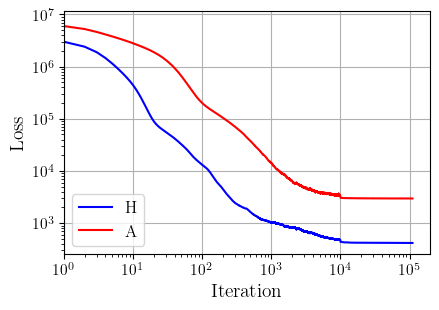

In [10]:
plt.figure(figsize=(width, height))

plt.plot(smooth_curve(train_total_loss_list_heterogeneous_problem), label='H', color='blue', linestyle='-')
plt.plot(smooth_curve(train_total_loss_list_tensorial_problem), label='A', color='red', linestyle='-')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

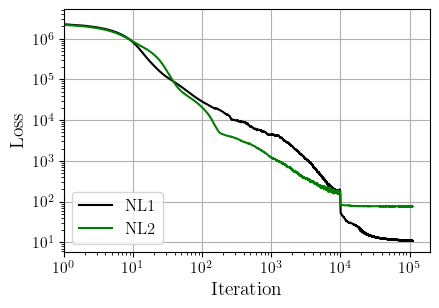

In [11]:
plt.figure(figsize=(width, height))

plt.plot(smooth_curve(train_total_loss_list_nonlinear_problem_P3), label='NL1', color='black', linestyle='-')
plt.plot(smooth_curve(train_total_loss_list_nonlinear_problem_P4), label='NL2', color='green', linestyle='-')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()